# Padim Example

#### Import dependencies

In [1]:
import os
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

c:\Users\abdulgader\AppData\Local\pypoetry\Cache\virtualenvs\padimopti-c3zqGkN3-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 

## Training

In this notebook the MVTec dataset will be used. It can be downloaded from: https://www.mvtec.com/company/research/datasets/mvtec-ad.

Change `DATASET_PATH` to the path where you save the dataset.

Also, if you want to save and load the model. Add a folder where to save them and change the path of `MODEL_DATA_PATH` to that folder.

In [2]:
DATASET_PATH = os.path.realpath(r"D:\01-DATA\bottle")
MODEL_DATA_PATH = os.path.realpath("./distributions/")
os.makedirs(MODEL_DATA_PATH,exist_ok=True)

#### Load dataset

In [3]:
dataset = anodet.AnodetDataset(os.path.join(DATASET_PATH, "train/good"))
dataloader = DataLoader(dataset, batch_size=2)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [4]:
padim = anodet.Padim(backbone='resnet18')


#### Fit the model to the dataset

In [5]:
padim.fit(dataloader)

Feature extraction: 100%|██████████| 105/105 [00:16<00:00,  6.37it/s]


#### Save the necessary parameters

In [6]:
distributions_path = './distributions/'
# torch.save(padim.mean, os.path.join(MODEL_DATA_PATH, "bottle_mean.pt"))
# torch.save(padim.cov_inv, os.path.join(MODEL_DATA_PATH, "bottle_cov_inv.pt"))

torch.save(padim, os.path.join(MODEL_DATA_PATH, "padim_model.pt"))


# 

## Inference
#### Load test images

In [7]:
paths = [
    os.path.join(DATASET_PATH, "test/broken_large/000.png"),
    os.path.join(DATASET_PATH, "test/broken_small/000.png"),
    os.path.join(DATASET_PATH, "test/contamination/000.png"),
    os.path.join(DATASET_PATH, "test/good/000.png"),
    os.path.join(DATASET_PATH, "test/good/001.png"),
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)



In [8]:
batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the model data

In [9]:
# model = torch.load(os.path.join(MODEL_DATA_PATH, 'padim_model.pt'))
# mean = torch.load(os.path.join(MODEL_DATA_PATH, 'padim_model.pt'))
# cov_inv = torch.load(os.path.join(MODEL_DATA_PATH, 'bottle_cov_inv.pt'))

#### init the model

In [10]:
# padim = anodet.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

In [11]:
image_scores, score_maps = padim.predict(batch)
print("Image Score:", image_scores)


Image Score: tensor([23.5405, 25.8136, 24.9945, 10.4788,  9.0693])


#### Interpret the prediction

In [12]:
THRESH = 13
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([23.5405, 25.8136, 24.9945, 10.4788,  9.0693])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

In [13]:
test_images = np.array(images).copy()

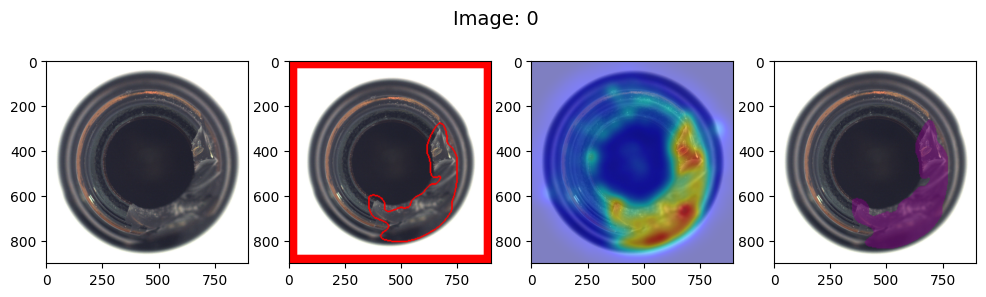

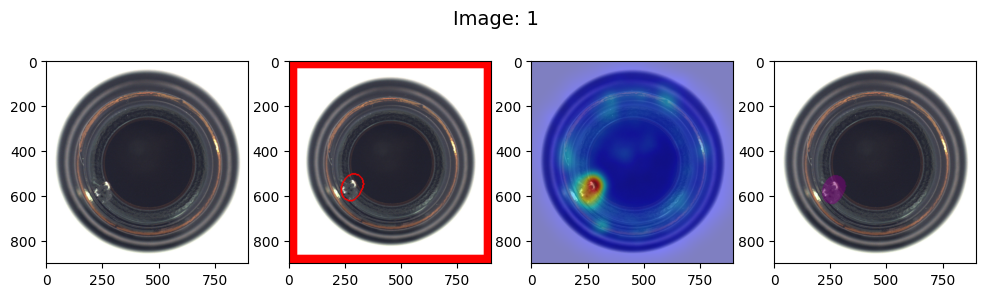

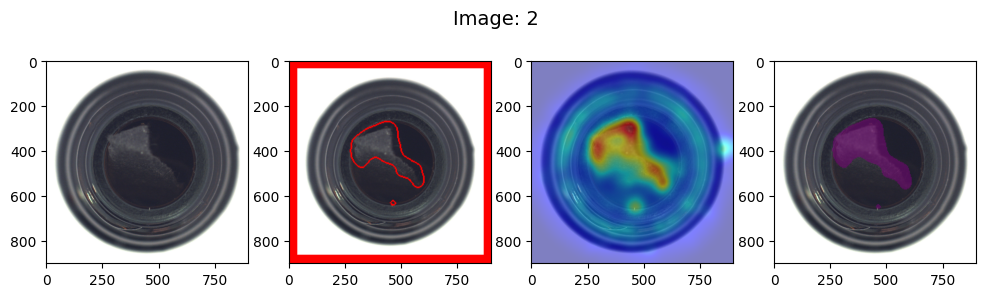

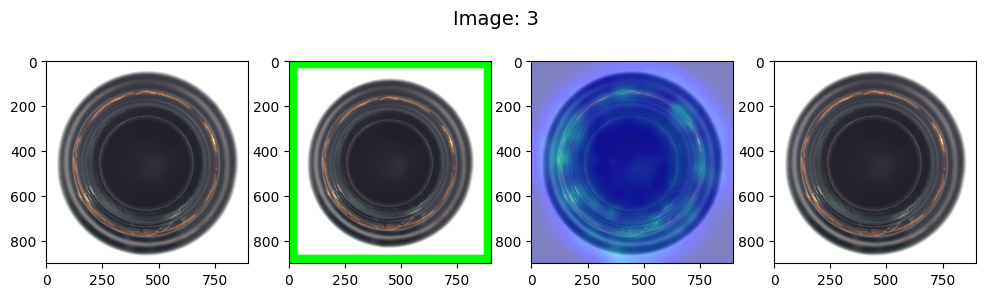

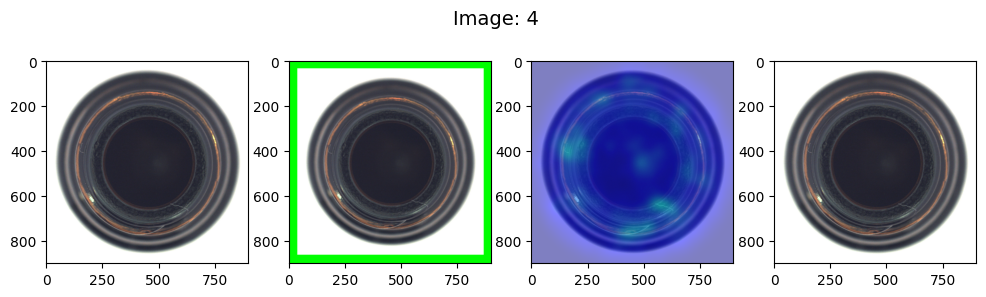

In [14]:
boundary_images = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
highlighted_images = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle('Image: ' + str(idx), y=0.75, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(boundary_images[idx])
    axs[2].imshow(heatmap_images[idx])
    axs[3].imshow(highlighted_images[idx])
    plt.show()

#### For one merged image

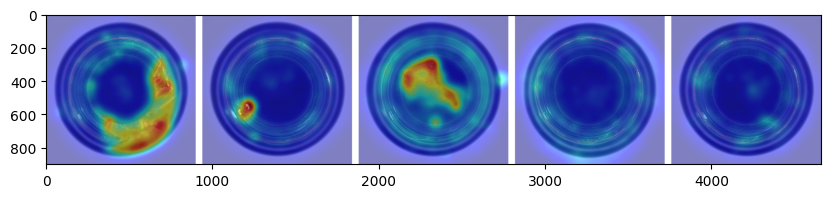

In [15]:
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
tot_img = anodet.visualization.merge_images(heatmap_images, margin=40)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.imshow(tot_img)
plt.show()

In [16]:
padim.export_onnx(os.path.join(MODEL_DATA_PATH, "padim_model.onnx"))

d:\Projects\anodet\anodet\utils.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert mean.shape[0] == cov_inv.shape[0]
d:\Projects\anodet\anodet\utils.py:89: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert mean.shape[1] == cov_inv.shape[1] == cov_inv.shape[2] == batch.shape[1]
d:\Projects\anodet\anodet\utils.py:90: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace mi

In [17]:
import onnxruntime as ort

import cv2


# --- Load ONNX model
onnx_model_path = os.path.join(MODEL_DATA_PATH, "padim_model.onnx")
session = ort.InferenceSession(
    onnx_model_path,
    providers=["CPUExecutionProvider"]
)


# --- Input and output names
input_name = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]
print("Input:", input_name)
print("Outputs:", output_names)

# --- Load and preprocess input image
def preprocess_image(image_path, input_size=(224, 224)):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    batch = anodet.to_batch([image], anodet.standard_image_transform, torch.device('cpu'))

    return batch.numpy()

# --- Run inference

paths = [
    os.path.join(DATASET_PATH, "test/broken_large/000.png"),
    os.path.join(DATASET_PATH, "test/broken_small/000.png"),
    os.path.join(DATASET_PATH, "test/contamination/000.png"),
    os.path.join(DATASET_PATH, "test/good/000.png"),
    os.path.join(DATASET_PATH, "test/good/001.png"),
]

for image_path in paths:
    input_tensor = preprocess_image(image_path)
    # print(input_tensor.shape)
    
    outputs = session.run(output_names, {input_name: input_tensor})

    # --- Postprocess
    image_scores = outputs[0]  # shape: (1,)
    score_map = outputs[1]     # shape: (1, H, W)

    print("Image Score:", image_scores[0])


Input: input
Outputs: ['image_scores', 'score_map']
Image Score: 23.540495
Image Score: 25.813602
Image Score: 24.994513
Image Score: 10.478806
Image Score: 9.069315


In [18]:
# import mlflow
# import mlflow.onnx
# import onnx

# # Load ONNX model as ModelProto object
# onnx_model = onnx.load("padim_model.onnx")

# mlflow.set_tracking_uri("file:./mlruns")  # Optional: use your server URI

# with mlflow.start_run(run_name="padim_onnx_export"):
#     mlflow.log_param("backbone", "resnet18")

#     # ✅ Correct: pass the ONNX model object, not path
#     mlflow.onnx.log_model(
#         onnx_model=onnx_model,
#         name="padim_model",
#         registered_model_name="PadimONNX"
#     )
